### Ces test sont réalisé en basent sur l'artcicle [How Are Idioms Processed Inside Transformer Language Models?](https://aclanthology.org/2023.starsem-1.16.pdf) avec des modelès multilangue avec des examples en francais et anglais.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

### Models

In [ ]:
distil_mbert_name = "distilbert-base-multilingual-cased"
mbert_name = "bert-base-multilingual-cased"
qwen_name = "Qwen/Qwen2.5-1.5B"

distil_mbert_tokenizer = AutoTokenizer.from_pretrained(distil_mbert_name)
distil_mbert_model = AutoModel.from_pretrained(distil_mbert_name, output_hidden_states=True, output_attentions=True)

mbert_tokenizer = AutoTokenizer.from_pretrained(mbert_name)
mbert_model = AutoModel.from_pretrained(mbert_name, output_hidden_states=True, output_attentions=True)

qwen_tokenizer = AutoTokenizer.from_pretrained(qwen_name)
qwen_model = AutoModel.from_pretrained(qwen_name, output_hidden_states=True, output_attentions=True)

distil_mbert_model.eval()
mbert_model.eval()
qwen_model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

Qwen2Model(
  (embed_tokens): Embedding(151936, 1536)
  (layers): ModuleList(
    (0-27): 28 x Qwen2DecoderLayer(
      (self_attn): Qwen2Attention(
        (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
        (k_proj): Linear(in_features=1536, out_features=256, bias=True)
        (v_proj): Linear(in_features=1536, out_features=256, bias=True)
        (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
      )
      (mlp): Qwen2MLP(
        (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
        (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
        (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
        (act_fn): SiLUActivation()
      )
      (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
    )
  )
  (norm): Qwen2RMSNorm((1536,), eps=1e-06)
  (rotary_emb): Qwen2RotaryEmbedding()
)

# Expérience 1 — Similarité des embeddings de phrases à travers les couches

In [ ]:
def get_sentence_embeddings(sentence, model, tokenizer):
    tokens = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
        hidden_states = outputs.hidden_states

    layer_embeddings = [torch.mean(hs.squeeze(0), dim=0) for hs in hidden_states]
    return layer_embeddings

In [ ]:
def layer_sim(idiom_layers, literal_layers):
    return [1 - cosine(x.numpy(), y.numpy()) for x, y in zip(idiom_layers, literal_layers)]

In [ ]:
idiom_en = "I’m feeling under the weather today."
literal_en = "I’m feeling unwell today."

idiom_fr = "Je ne suis pas dans mon assiette aujourd'hui"
literal_fr = "Je ne me sens pas bien aujourd’hui."

## Distil MBert_model

In [ ]:
# creation des embeddings
distil_idiom_en_layers = get_sentence_embeddings(idiom_en, distil_mbert_model, distil_mbert_tokenizer)
distil_literal_en_layers = get_sentence_embeddings(literal_en, distil_mbert_model, distil_mbert_tokenizer)

distil_idiom_fr_layers = get_sentence_embeddings(idiom_fr, distil_mbert_model, distil_mbert_tokenizer)
distil_literal_fr_layers = get_sentence_embeddings(literal_fr, distil_mbert_model, distil_mbert_tokenizer)


distil_sim_en = layer_sim(distil_idiom_en_layers, distil_literal_en_layers)
distil_sim_fr = layer_sim(distil_idiom_fr_layers, distil_literal_fr_layers)

distil_sim_tra_idiom = layer_sim(distil_idiom_en_layers, distil_idiom_fr_layers)
distil_sim_tra_literal = layer_sim(distil_literal_en_layers, distil_literal_fr_layers)


print("=== French Idiom vs French Literal ===")
for i, sim in enumerate(distil_sim_fr):
    print(f"Layer {i}: similarity = {sim:.4f}")

print("\n=== English Idiom vs English Literal ===")
for i, sim in enumerate(distil_sim_en):
    print(f"Layer {i}: similarity = {sim:.4f}")

print("\n=== English Idiom vs French Idiom ===")
for i, sim in enumerate(distil_sim_tra_idiom):
    print(f"Layer {i}: similarity = {sim:.4f}")

print("\n=== English Literal vs French Literal ===")
for i, sim in enumerate(distil_sim_tra_literal):
    print(f"Layer {i}: similarity = {sim:.4f}")

=== French Idiom vs French Literal ===
Layer 0: similarity = 0.6638
Layer 1: similarity = 0.8902
Layer 2: similarity = 0.9362
Layer 3: similarity = 0.9438
Layer 4: similarity = 0.9490
Layer 5: similarity = 0.9798
Layer 6: similarity = 0.8828

=== English Idiom vs English Literal ===
Layer 0: similarity = 0.7756
Layer 1: similarity = 0.9353
Layer 2: similarity = 0.9520
Layer 3: similarity = 0.9654
Layer 4: similarity = 0.9739
Layer 5: similarity = 0.9885
Layer 6: similarity = 0.9423

=== English Idiom vs French Idiom ===
Layer 0: similarity = 0.2328
Layer 1: similarity = 0.6964
Layer 2: similarity = 0.8280
Layer 3: similarity = 0.8784
Layer 4: similarity = 0.8832
Layer 5: similarity = 0.9393
Layer 6: similarity = 0.5954

=== English Literal vs French Literal ===
Layer 0: similarity = 0.4395
Layer 1: similarity = 0.7728
Layer 2: similarity = 0.8384
Layer 3: similarity = 0.8913
Layer 4: similarity = 0.8940
Layer 5: similarity = 0.9455
Layer 6: similarity = 0.6328


## MBert_model

In [ ]:
mbert_idiom_en_layers = get_sentence_embeddings(idiom_en, mbert_model, mbert_tokenizer)
mbert_literal_en_layers = get_sentence_embeddings(literal_en, mbert_model, mbert_tokenizer)

mbert_idiom_fr_layers = get_sentence_embeddings(idiom_fr, mbert_model, mbert_tokenizer)
mbert_literal_fr_layers = get_sentence_embeddings(literal_fr, mbert_model, mbert_tokenizer)


mbert_sim_en = layer_sim(mbert_idiom_en_layers, mbert_literal_en_layers)
mbert_sim_fr = layer_sim(mbert_idiom_fr_layers, mbert_literal_fr_layers)

mbert_sim_tra_idiom = layer_sim(mbert_idiom_en_layers, mbert_idiom_fr_layers)
mbert_sim_tra_literal = layer_sim(mbert_literal_en_layers, mbert_literal_fr_layers)


print("=== French Idiom vs French Literal ===")
for i, sim in enumerate(mbert_sim_fr):
    print(f"Layer {i}: similarity = {sim:.4f}")

print("\n=== English Idiom vs English Literal ===")
for i, sim in enumerate(mbert_sim_en):
    print(f"Layer {i}: similarity = {sim:.4f}")

print("\n=== English Idiom vs French Idiom ===")
for i, sim in enumerate(mbert_sim_tra_idiom):
    print(f"Layer {i}: similarity = {sim:.4f}")

print("\n=== English Literal vs French Literal ===")
for i, sim in enumerate(mbert_sim_tra_literal):
    print(f"Layer {i}: similarity = {sim:.4f}")

=== French Idiom vs French Literal ===
Layer 0: similarity = 0.7502
Layer 1: similarity = 0.8430
Layer 2: similarity = 0.8684
Layer 3: similarity = 0.9173
Layer 4: similarity = 0.9284
Layer 5: similarity = 0.9407
Layer 6: similarity = 0.9320
Layer 7: similarity = 0.8634
Layer 8: similarity = 0.8359
Layer 9: similarity = 0.8839
Layer 10: similarity = 0.9090
Layer 11: similarity = 0.9251
Layer 12: similarity = 0.7394

=== English Idiom vs English Literal ===
Layer 0: similarity = 0.8482
Layer 1: similarity = 0.9079
Layer 2: similarity = 0.9184
Layer 3: similarity = 0.9488
Layer 4: similarity = 0.9551
Layer 5: similarity = 0.9684
Layer 6: similarity = 0.9748
Layer 7: similarity = 0.9607
Layer 8: similarity = 0.9480
Layer 9: similarity = 0.9657
Layer 10: similarity = 0.9738
Layer 11: similarity = 0.9756
Layer 12: similarity = 0.9165

=== English Idiom vs French Idiom ===
Layer 0: similarity = 0.4179
Layer 1: similarity = 0.6207
Layer 2: similarity = 0.6624
Layer 3: similarity = 0.7989
Laye

## Qwen Model

In [ ]:
qwen_idiom_en_layers = get_sentence_embeddings(idiom_en, qwen_model, qwen_tokenizer)
qwen_literal_en_layers = get_sentence_embeddings(literal_en, qwen_model, qwen_tokenizer)

qwen_idiom_fr_layers = get_sentence_embeddings(idiom_fr, qwen_model, qwen_tokenizer)
qwen_literal_fr_layers = get_sentence_embeddings(literal_fr, qwen_model, qwen_tokenizer)


qwen_sim_en = layer_sim(qwen_idiom_en_layers, qwen_literal_en_layers)
qwen_sim_fr = layer_sim(qwen_idiom_fr_layers, qwen_literal_fr_layers)

qwen_sim_tra_idiom = layer_sim(qwen_idiom_en_layers, qwen_idiom_fr_layers)
qwen_sim_tra_literal = layer_sim(qwen_literal_en_layers, qwen_literal_fr_layers)


print("=== French Idiom vs French Literal ===")
for i, sim in enumerate(qwen_sim_fr):
    print(f"Layer {i}: similarity = {sim:.4f}")

print("\n=== English Idiom vs English Literal ===")
for i, sim in enumerate(qwen_sim_en):
    print(f"Layer {i}: similarity = {sim:.4f}")

print("\n=== English Idiom vs French Idiom ===")
for i, sim in enumerate(qwen_sim_tra_idiom):
    print(f"Layer {i}: similarity = {sim:.4f}")

print("\n=== English Literal vs French Literal ===")
for i, sim in enumerate(qwen_sim_tra_literal):
    print(f"Layer {i}: similarity = {sim:.4f}")

=== French Idiom vs French Literal ===
Layer 0: similarity = 0.5637
Layer 1: similarity = 0.8802
Layer 2: similarity = 0.9999
Layer 3: similarity = 1.0000
Layer 4: similarity = 0.9999
Layer 5: similarity = 0.9999
Layer 6: similarity = 0.9999
Layer 7: similarity = 0.9999
Layer 8: similarity = 0.9999
Layer 9: similarity = 0.9999
Layer 10: similarity = 0.9999
Layer 11: similarity = 0.9999
Layer 12: similarity = 0.9998
Layer 13: similarity = 0.9998
Layer 14: similarity = 0.9998
Layer 15: similarity = 0.9998
Layer 16: similarity = 0.9998
Layer 17: similarity = 0.9998
Layer 18: similarity = 0.9998
Layer 19: similarity = 0.9998
Layer 20: similarity = 0.9997
Layer 21: similarity = 0.9997
Layer 22: similarity = 0.9996
Layer 23: similarity = 0.9994
Layer 24: similarity = 0.9991
Layer 25: similarity = 0.9986
Layer 26: similarity = 0.9982
Layer 27: similarity = 0.9602
Layer 28: similarity = 0.9736

=== English Idiom vs English Literal ===
Layer 0: similarity = 0.7317
Layer 1: similarity = 0.8665
L

## Résultat

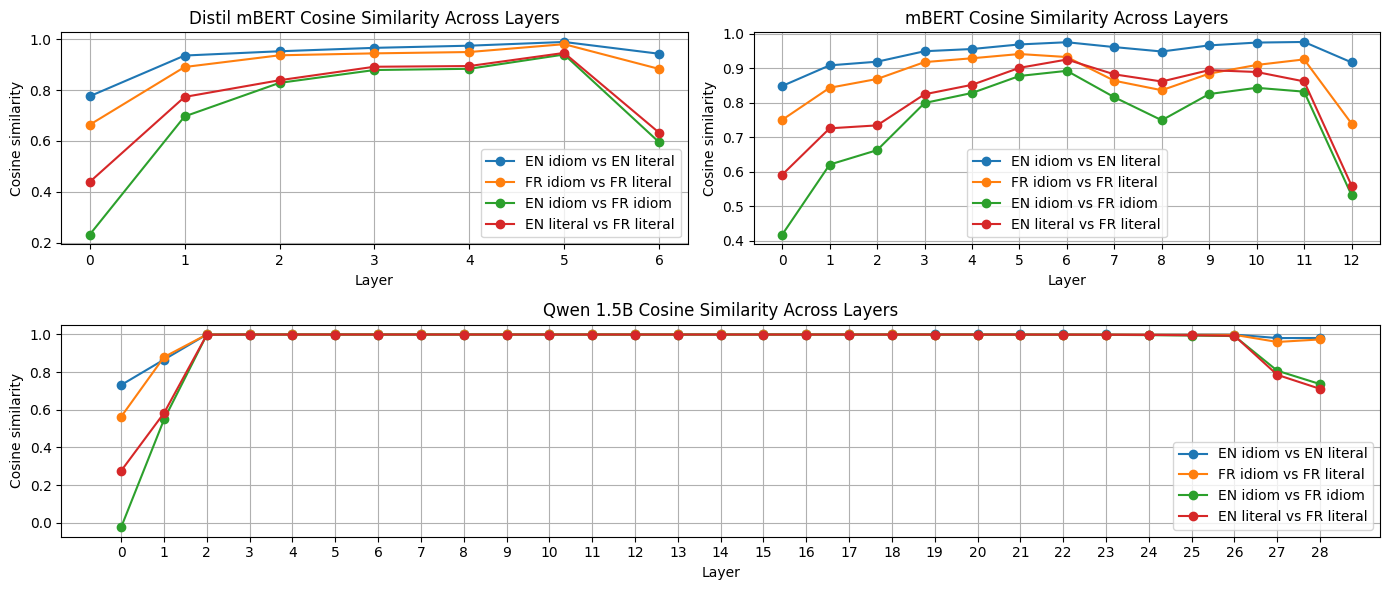

In [ ]:
plt.figure(figsize=(14,6))

# DistilBERT plot
plt.subplot(2, 2, 1)
plt.plot(distil_sim_en, marker='o', label="EN idiom vs EN literal")
plt.plot(distil_sim_fr, marker='o', label="FR idiom vs FR literal")
plt.plot(distil_sim_tra_idiom, marker='o', label="EN idiom vs FR idiom")
plt.plot(distil_sim_tra_literal, marker='o', label="EN literal vs FR literal")
plt.title("Distil mBERT Cosine Similarity Across Layers")
plt.xlabel("Layer")
plt.ylabel("Cosine similarity")
plt.xticks(range(len(distil_sim_en)))
plt.grid(True)
plt.legend()

# mBERT plot
plt.subplot(2, 2, 2)
plt.plot(mbert_sim_en, marker='o', label="EN idiom vs EN literal")
plt.plot(mbert_sim_fr, marker='o', label="FR idiom vs FR literal")
plt.plot(mbert_sim_tra_idiom, marker='o', label="EN idiom vs FR idiom")
plt.plot(mbert_sim_tra_literal, marker='o', label="EN literal vs FR literal")
plt.title("mBERT Cosine Similarity Across Layers")
plt.xlabel("Layer")
plt.ylabel("Cosine similarity")
plt.xticks(range(len(mbert_sim_en)))
plt.grid(True)
plt.legend()

# Qwen plot
plt.subplot(2, 1, 2)
plt.plot(qwen_sim_en, marker='o', label="EN idiom vs EN literal")
plt.plot(qwen_sim_fr, marker='o', label="FR idiom vs FR literal")
plt.plot(qwen_sim_tra_idiom, marker='o', label="EN idiom vs FR idiom")
plt.plot(qwen_sim_tra_literal, marker='o', label="EN literal vs FR literal")
plt.title("Qwen 1.5B Cosine Similarity Across Layers")
plt.xlabel("Layer")
plt.ylabel("Cosine similarity")
plt.xticks(range(len(qwen_sim_en)))
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Expérience 2 : Évolution du plongement lexical en contexte idiomatique comparé au contexte littéral



In [ ]:
def get_word_embeddings(sentence, target_word, model, tokenizer):
    tokens = tokenizer(sentence, return_tensors="pt")
    input_ids = tokens["input_ids"][0]

    token_ids = tokenizer.encode(target_word, add_special_tokens=False)

    # find first occurrence
    for idx in range(len(input_ids)-len(token_ids)):
        if torch.equal(input_ids[idx:idx+len(token_ids)], torch.tensor(token_ids)):
            word_idx = idx
            break

    with torch.no_grad():
        outputs = model(**tokens)
        hidden_states = outputs.hidden_states

    word_embeds = [hs[0, word_idx, :] for hs in hidden_states]
    return word_embeds

In [ ]:
idiom_en = "To start the meeting, he told a joke to break the ice."
literal_en = "The winter was so cold that the ice on the lake froze solid."
target_en = " ice"

idiom_fr = "Pour commencer la réunion, il a raconté une blague pour briser la glace."
literal_fr = "J'ai glissé sur la glace en sortant de chez moi ce matin."
literal_fr_2 = "C'est l'été, j'aime manger une glace à la vanille sur la plage."
target_fr = " glace"

## Distil MBert_model

In [ ]:
# creation des embeddings
distil_idiom_en_layers = get_word_embeddings(idiom_en, target_en, distil_mbert_model, distil_mbert_tokenizer)
distil_literal_en_layers = get_word_embeddings(literal_en, target_en, distil_mbert_model, distil_mbert_tokenizer)

distil_idiom_fr_layers = get_word_embeddings(idiom_fr, target_fr, distil_mbert_model, distil_mbert_tokenizer)
distil_literal_fr_layers = get_word_embeddings(literal_fr, target_fr, distil_mbert_model, distil_mbert_tokenizer)
distil_literal_fr_layers_2 = get_word_embeddings(literal_fr_2, target_fr, distil_mbert_model, distil_mbert_tokenizer)


distil_sim_en = layer_sim(distil_idiom_en_layers, distil_literal_en_layers)
distil_sim_fr = layer_sim(distil_idiom_fr_layers, distil_literal_fr_layers)
distil_sim_fr_2 = layer_sim(distil_idiom_fr_layers, distil_literal_fr_layers_2)

distil_sim_tra_idiom = layer_sim(distil_idiom_en_layers, distil_idiom_fr_layers)
distil_sim_tra_literal = layer_sim(distil_literal_en_layers, distil_literal_fr_layers)


print("=== French Idiom vs French Literal ===")
for i, sim in enumerate(distil_sim_fr):
    print(f"Layer {i}: similarity = {sim:.4f}")

print("=== French Idiom vs French Literal 2 ===")
for i, sim in enumerate(distil_sim_fr_2):
    print(f"Layer {i}: similarity = {sim:.4f}")

print("\n=== English Idiom vs English Literal ===")
for i, sim in enumerate(distil_sim_en):
    print(f"Layer {i}: similarity = {sim:.4f}")

print("\n=== English Idiom vs French Idiom ===")
for i, sim in enumerate(distil_sim_tra_idiom):
    print(f"Layer {i}: similarity = {sim:.4f}")

print("\n=== English Literal vs French Literal ===")
for i, sim in enumerate(distil_sim_tra_literal):
    print(f"Layer {i}: similarity = {sim:.4f}")

=== French Idiom vs French Literal ===
Layer 0: similarity = 0.9595
Layer 1: similarity = 0.9223
Layer 2: similarity = 0.9310
Layer 3: similarity = 0.9251
Layer 4: similarity = 0.9314
Layer 5: similarity = 0.9711
Layer 6: similarity = 0.8926
=== French Idiom vs French Literal 2 ===
Layer 0: similarity = 0.9709
Layer 1: similarity = 0.9264
Layer 2: similarity = 0.9201
Layer 3: similarity = 0.9213
Layer 4: similarity = 0.9180
Layer 5: similarity = 0.9642
Layer 6: similarity = 0.8814

=== English Idiom vs English Literal ===
Layer 0: similarity = 0.9759
Layer 1: similarity = 0.9332
Layer 2: similarity = 0.8808
Layer 3: similarity = 0.8791
Layer 4: similarity = 0.8870
Layer 5: similarity = 0.9423
Layer 6: similarity = 0.7599

=== English Idiom vs French Idiom ===
Layer 0: similarity = 0.4068
Layer 1: similarity = 0.5688
Layer 2: similarity = 0.7210
Layer 3: similarity = 0.8073
Layer 4: similarity = 0.8457
Layer 5: similarity = 0.9427
Layer 6: similarity = 0.6500

=== English Literal vs Fre

## MBert_model

In [ ]:
# creation des embeddings
mbert_idiom_en_layers = get_word_embeddings(idiom_en, target_en, mbert_model, mbert_tokenizer)
mbert_literal_en_layers = get_word_embeddings(literal_en, target_en, mbert_model, mbert_tokenizer)

mbert_idiom_fr_layers = get_word_embeddings(idiom_fr, target_fr, mbert_model, mbert_tokenizer)
mbert_literal_fr_layers = get_word_embeddings(literal_fr, target_fr, mbert_model, mbert_tokenizer)
mbert_literal_fr_layers_2 = get_word_embeddings(literal_fr_2, target_fr, mbert_model, mbert_tokenizer)


mbert_sim_en = layer_sim(mbert_idiom_en_layers, mbert_literal_en_layers)
mbert_sim_fr = layer_sim(mbert_idiom_fr_layers, mbert_literal_fr_layers)
mbert_sim_fr_2 = layer_sim(mbert_idiom_fr_layers, mbert_literal_fr_layers_2)

mbert_sim_tra_idiom = layer_sim(mbert_idiom_en_layers, mbert_idiom_fr_layers)
mbert_sim_tra_literal = layer_sim(mbert_literal_en_layers, mbert_literal_fr_layers)


print("=== French Idiom vs French Literal ===")
for i, sim in enumerate(mbert_sim_fr):
    print(f"Layer {i}: similarity = {sim:.4f}")

print("=== French Idiom vs French Literal 2 ===")
for i, sim in enumerate(mbert_sim_fr_2):
    print(f"Layer {i}: similarity = {sim:.4f}")

print("\n=== English Idiom vs English Literal ===")
for i, sim in enumerate(mbert_sim_en):
    print(f"Layer {i}: similarity = {sim:.4f}")

print("\n=== English Idiom vs French Idiom ===")
for i, sim in enumerate(mbert_sim_tra_idiom):
    print(f"Layer {i}: similarity = {sim:.4f}")

print("\n=== English Literal vs French Literal ===")
for i, sim in enumerate(mbert_sim_tra_literal):
    print(f"Layer {i}: similarity = {sim:.4f}")

=== French Idiom vs French Literal ===
Layer 0: similarity = 0.9574
Layer 1: similarity = 0.9388
Layer 2: similarity = 0.9049
Layer 3: similarity = 0.9210
Layer 4: similarity = 0.9213
Layer 5: similarity = 0.9267
Layer 6: similarity = 0.9152
Layer 7: similarity = 0.8759
Layer 8: similarity = 0.8605
Layer 9: similarity = 0.8990
Layer 10: similarity = 0.9151
Layer 11: similarity = 0.9197
Layer 12: similarity = 0.7370
=== French Idiom vs French Literal 2 ===
Layer 0: similarity = 0.9701
Layer 1: similarity = 0.9559
Layer 2: similarity = 0.9244
Layer 3: similarity = 0.9262
Layer 4: similarity = 0.9222
Layer 5: similarity = 0.9314
Layer 6: similarity = 0.9089
Layer 7: similarity = 0.8644
Layer 8: similarity = 0.8493
Layer 9: similarity = 0.8702
Layer 10: similarity = 0.9014
Layer 11: similarity = 0.9170
Layer 12: similarity = 0.7466

=== English Idiom vs English Literal ===
Layer 0: similarity = 0.9704
Layer 1: similarity = 0.9418
Layer 2: similarity = 0.8734
Layer 3: similarity = 0.8808
La

## Qwen Model

In [ ]:
# creation des embeddings
qwen_idiom_en_layers = get_word_embeddings(idiom_en, target_en, qwen_model, qwen_tokenizer)
qwen_literal_en_layers = get_word_embeddings(literal_en, target_en, qwen_model, qwen_tokenizer)

qwen_idiom_fr_layers = get_word_embeddings(idiom_fr, target_fr, qwen_model, qwen_tokenizer)
qwen_literal_fr_layers = get_word_embeddings(literal_fr, target_fr, qwen_model, qwen_tokenizer)
qwen_literal_fr_layers_2 = get_word_embeddings(literal_fr_2, target_fr, qwen_model, qwen_tokenizer)


qwen_sim_en = layer_sim(qwen_idiom_en_layers, qwen_literal_en_layers)
qwen_sim_fr = layer_sim(qwen_idiom_fr_layers, qwen_literal_fr_layers)
qwen_sim_fr_2 = layer_sim(qwen_idiom_fr_layers, qwen_literal_fr_layers_2)

qwen_sim_tra_idiom = layer_sim(qwen_idiom_en_layers, qwen_idiom_fr_layers)
qwen_sim_tra_literal = layer_sim(qwen_literal_en_layers, qwen_literal_fr_layers)


print("=== French Idiom vs French Literal ===")
for i, sim in enumerate(qwen_sim_fr):
    print(f"Layer {i}: similarity = {sim:.4f}")

print("=== French Idiom vs French Literal 2 ===")
for i, sim in enumerate(qwen_sim_fr_2):
    print(f"Layer {i}: similarity = {sim:.4f}")

print("\n=== English Idiom vs English Literal ===")
for i, sim in enumerate(qwen_sim_en):
    print(f"Layer {i}: similarity = {sim:.4f}")

print("\n=== English Idiom vs French Idiom ===")
for i, sim in enumerate(qwen_sim_tra_idiom):
    print(f"Layer {i}: similarity = {sim:.4f}")

print("\n=== English Literal vs French Literal ===")
for i, sim in enumerate(qwen_sim_tra_literal):
    print(f"Layer {i}: similarity = {sim:.4f}")

=== French Idiom vs French Literal ===
Layer 0: similarity = 1.0000
Layer 1: similarity = 0.9785
Layer 2: similarity = 0.9751
Layer 3: similarity = 0.9762
Layer 4: similarity = 0.9738
Layer 5: similarity = 0.9533
Layer 6: similarity = 0.9341
Layer 7: similarity = 0.9106
Layer 8: similarity = 0.9033
Layer 9: similarity = 0.9122
Layer 10: similarity = 0.9089
Layer 11: similarity = 0.9058
Layer 12: similarity = 0.8843
Layer 13: similarity = 0.8833
Layer 14: similarity = 0.8740
Layer 15: similarity = 0.8832
Layer 16: similarity = 0.8861
Layer 17: similarity = 0.8885
Layer 18: similarity = 0.8849
Layer 19: similarity = 0.8787
Layer 20: similarity = 0.9079
Layer 21: similarity = 0.8977
Layer 22: similarity = 0.9114
Layer 23: similarity = 0.9345
Layer 24: similarity = 0.9300
Layer 25: similarity = 0.9158
Layer 26: similarity = 0.8994
Layer 27: similarity = 0.8748
Layer 28: similarity = 0.8684
=== French Idiom vs French Literal 2 ===
Layer 0: similarity = 1.0000
Layer 1: similarity = 0.9662
La

## Résultats

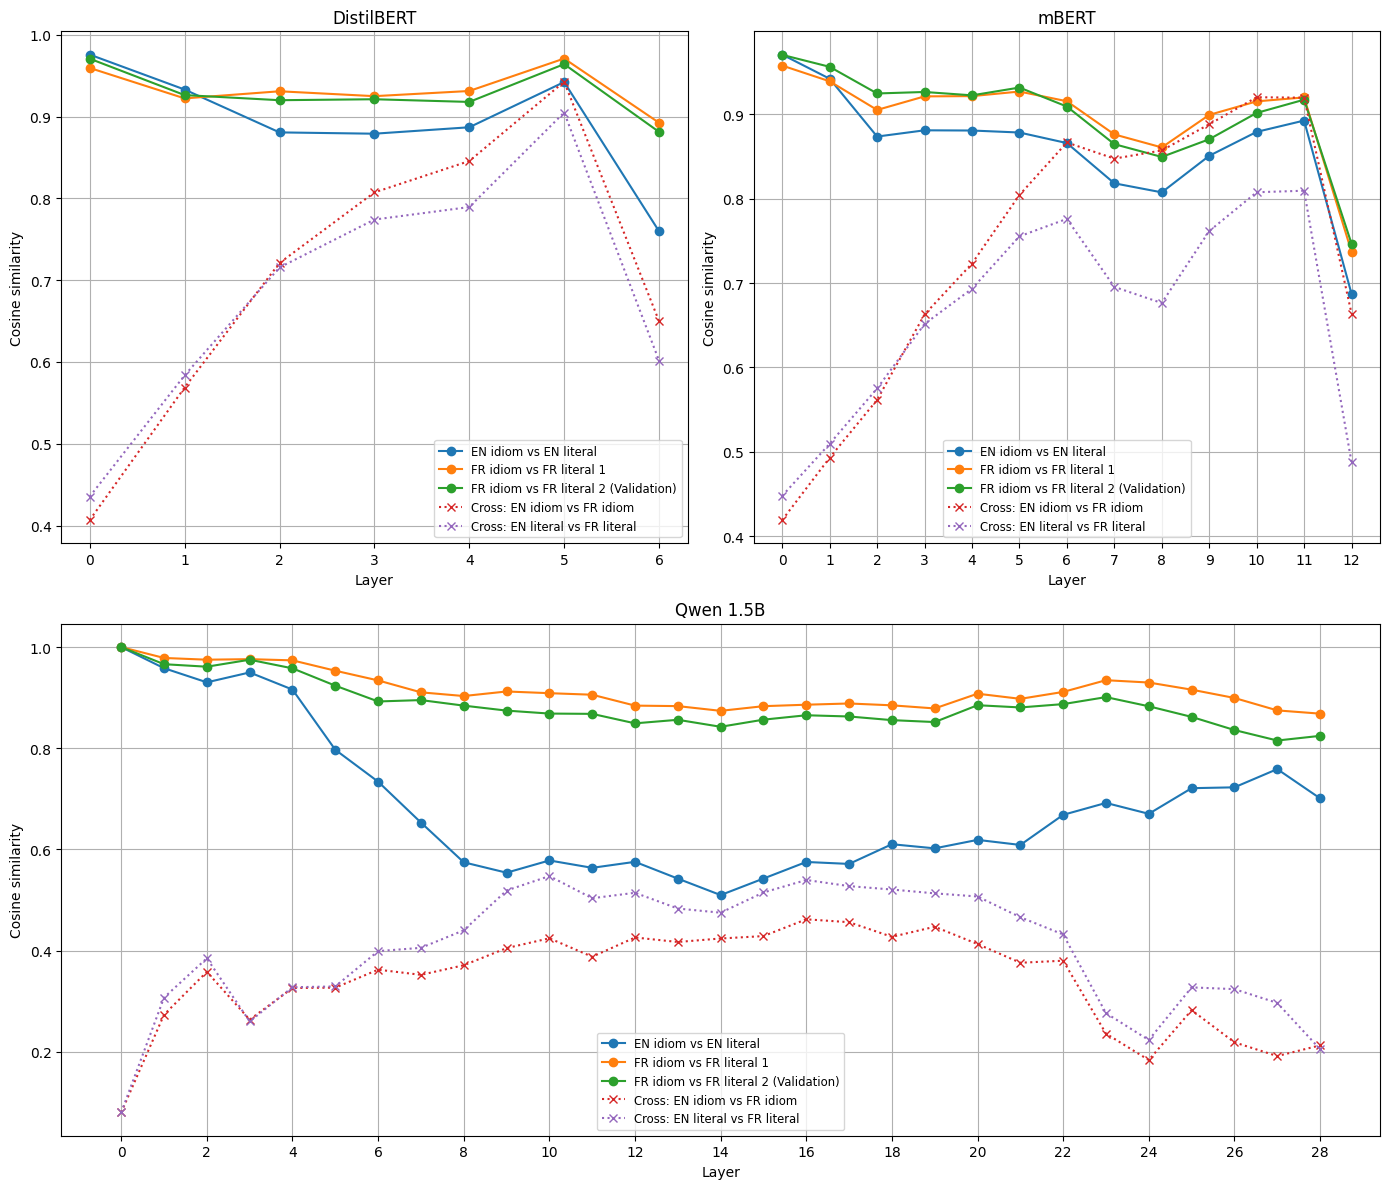

In [ ]:
plt.figure(figsize=(14, 12))

# --- 1. DistilBERT Plot ---
plt.subplot(2, 2, 1)
plt.plot(distil_sim_en, marker='o', label="EN idiom vs EN literal")
plt.plot(distil_sim_fr, marker='o', label="FR idiom vs FR literal 1")
plt.plot(distil_sim_fr_2, marker='o', label="FR idiom vs FR literal 2 (Validation)")
plt.plot(distil_sim_tra_idiom, marker='x', linestyle=':', label="Cross: EN idiom vs FR idiom")
plt.plot(distil_sim_tra_literal, marker='x', linestyle=':', label="Cross: EN literal vs FR literal")

plt.title("DistilBERT")
plt.xlabel("Layer")
plt.ylabel("Cosine similarity")
plt.xticks(range(len(distil_sim_en)))
plt.grid(True)
plt.legend(fontsize='small')

# --- 2. mBERT Plot ---
plt.subplot(2, 2, 2)
plt.plot(mbert_sim_en, marker='o', label="EN idiom vs EN literal")
plt.plot(mbert_sim_fr, marker='o', label="FR idiom vs FR literal 1")
plt.plot(mbert_sim_fr_2, marker='o', label="FR idiom vs FR literal 2 (Validation)")
plt.plot(mbert_sim_tra_idiom, marker='x', linestyle=':', label="Cross: EN idiom vs FR idiom")
plt.plot(mbert_sim_tra_literal, marker='x', linestyle=':', label="Cross: EN literal vs FR literal")

plt.title("mBERT")
plt.xlabel("Layer")
plt.ylabel("Cosine similarity")
plt.xticks(range(len(mbert_sim_en)))
plt.grid(True)
plt.legend(fontsize='small')

# --- 3. Qwen Plot ---
plt.subplot(2, 1, 2)
plt.plot(qwen_sim_en, marker='o', label="EN idiom vs EN literal")
plt.plot(qwen_sim_fr, marker='o', label="FR idiom vs FR literal 1")
plt.plot(qwen_sim_fr_2, marker='o', label="FR idiom vs FR literal 2 (Validation)")
plt.plot(qwen_sim_tra_idiom, marker='x', linestyle=':', label="Cross: EN idiom vs FR idiom")
plt.plot(qwen_sim_tra_literal, marker='x', linestyle=':', label="Cross: EN literal vs FR literal")

plt.title("Qwen 1.5B")
plt.xlabel("Layer")
plt.ylabel("Cosine similarity")
plt.xticks(range(0, len(qwen_sim_en), 2))
plt.grid(True)
plt.legend(fontsize='small', loc='lower center')

plt.tight_layout()
plt.show()

# Expérience 3: Attention portée par les autres tokens vers le mot cible

In [ ]:
def get_attention_score(sentence, target_word, model, tokenizer):
    inputs = tokenizer(sentence, return_tensors="pt")
    input_ids = inputs["input_ids"][0]

    token_ids = tokenizer.encode(target_word, add_special_tokens=False)

    target_idx = -1
    for idx in range(len(input_ids) - len(token_ids) + 1):
        if torch.equal(input_ids[idx:idx+len(token_ids)], torch.tensor(token_ids)):
            target_idx = idx
            break

    with torch.no_grad():
        outputs = model(**inputs)
        attentions = outputs.attentions

    layer_attention_scores = []

    for layer_attn in attentions:
        # 1. On moyenne sur les têtes d'attention (dim 1) -> [1, seq_len, seq_len]
        avg_heads = torch.mean(layer_attn, dim=1).squeeze(0)

        # 2. On extrait la colonne correspondant au mot cible
        attention_to_target = avg_heads[:, target_idx] # Shape: [seq_len]

        # 3. On calcule la moyenne de l'attention venant des AUTRES tokens
        # On exclut l'attention du mot vers lui-même (self-attention)
        mask = torch.ones_like(attention_to_target, dtype=torch.bool)
        mask[target_idx] = False

        # Moyenne des valeurs restantes
        avg_score = torch.mean(attention_to_target[mask]).item()
        layer_attention_scores.append(avg_score)

    return layer_attention_scores

In [ ]:
idiom_en = "To start the meeting, he told a joke to break the ice."
literal_en = "The winter was so cold that the ice on the lake froze solid."
target_en = " ice"

idiom_fr = "Pour commencer la réunion, il a raconté une blague pour briser la glace."
literal_fr = "J'ai glissé sur la glace en sortant de chez moi ce matin."
target_fr = " glace"

## Models

In [ ]:
#DistilmBERT
distil_att_idiom_en = get_attention_score(idiom_en, target_en, distil_mbert_model, distil_mbert_tokenizer)
distil_att_literal_en = get_attention_score(literal_en, target_en, distil_mbert_model, distil_mbert_tokenizer)

distil_att_idiom_fr = get_attention_score(idiom_fr, target_fr, distil_mbert_model, distil_mbert_tokenizer)
distil_att_literal_fr = get_attention_score(literal_fr, target_fr, distil_mbert_model, distil_mbert_tokenizer)

# mBERT
mbert_att_idiom_en = get_attention_score(idiom_en, target_en, mbert_model, mbert_tokenizer)
mbert_att_literal_en = get_attention_score(literal_en, target_en, mbert_model, mbert_tokenizer)

mbert_att_idiom_fr = get_attention_score(idiom_fr, target_fr, mbert_model, mbert_tokenizer)
mbert_att_literal_fr = get_attention_score(literal_fr, target_fr, mbert_model, mbert_tokenizer)

# Qwen
qwen_att_idiom_en = get_attention_score(idiom_en, target_en, qwen_model, qwen_tokenizer)
qwen_att_literal_en = get_attention_score(literal_en, target_en, qwen_model, qwen_tokenizer)

qwen_att_idiom_fr = get_attention_score(idiom_fr, target_fr, qwen_model, qwen_tokenizer)
qwen_att_literal_fr = get_attention_score(literal_fr, target_fr, qwen_model, qwen_tokenizer)

## Résultats

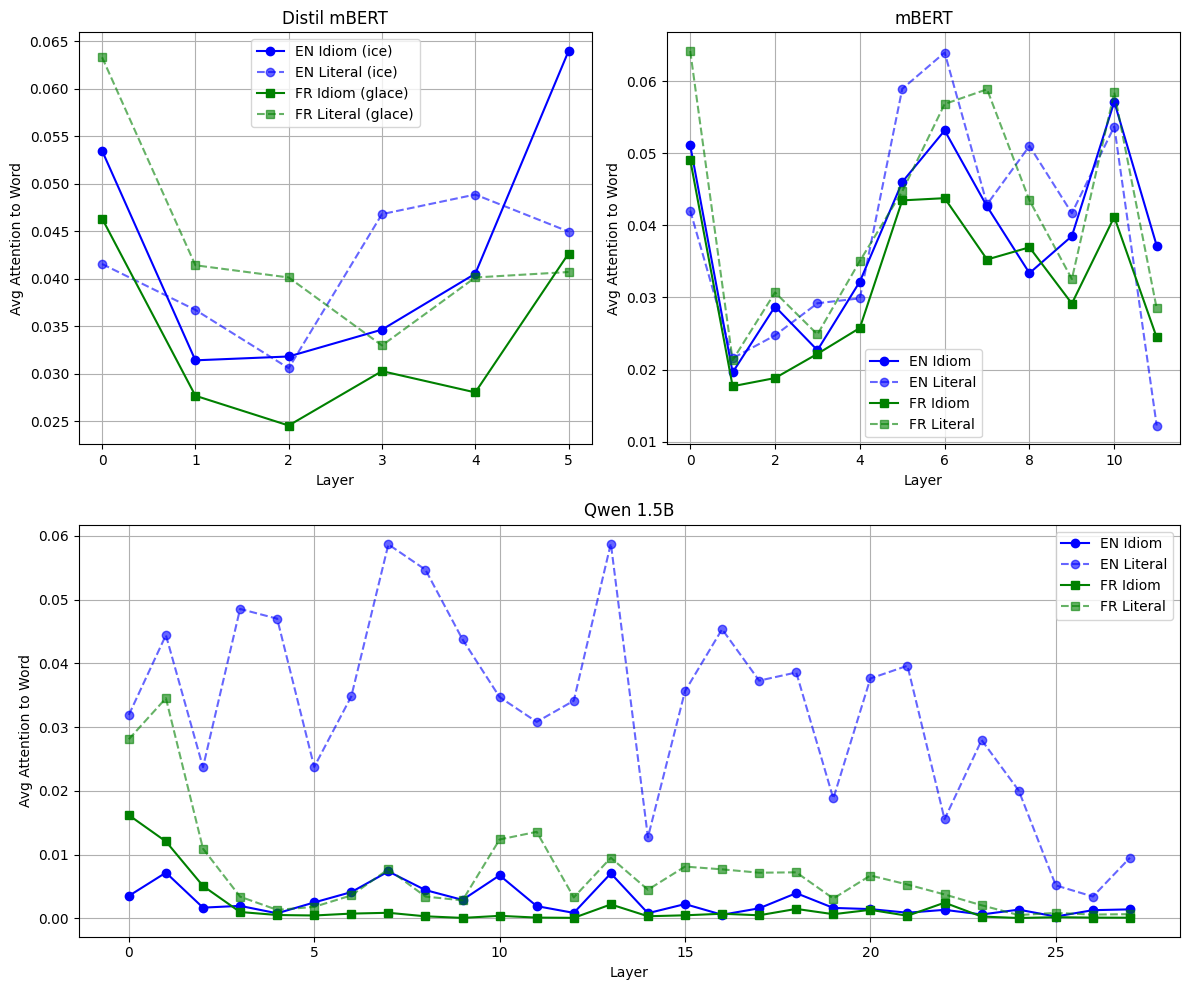

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(distil_att_idiom_en, marker='o', linestyle='-', color='blue', label="EN Idiom (ice)")
plt.plot(distil_att_literal_en, marker='o', linestyle='--', color='blue', alpha=0.6, label="EN Literal (ice)")
plt.plot(distil_att_idiom_fr, marker='s', linestyle='-', color='green', label="FR Idiom (glace)")
plt.plot(distil_att_literal_fr, marker='s', linestyle='--', color='green', alpha=0.6, label="FR Literal (glace)")
plt.title("Distil mBERT")
plt.xlabel("Layer")
plt.ylabel("Avg Attention to Word")
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(mbert_att_idiom_en, marker='o', linestyle='-', color='blue', label="EN Idiom")
plt.plot(mbert_att_literal_en, marker='o', linestyle='--', color='blue', alpha=0.6, label="EN Literal")
plt.plot(mbert_att_idiom_fr, marker='s', linestyle='-', color='green', label="FR Idiom")
plt.plot(mbert_att_literal_fr, marker='s', linestyle='--', color='green', alpha=0.6, label="FR Literal")
plt.title("mBERT")
plt.xlabel("Layer")
plt.ylabel("Avg Attention to Word")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(qwen_att_idiom_en, marker='o', linestyle='-', color='blue', label="EN Idiom")
plt.plot(qwen_att_literal_en, marker='o', linestyle='--', color='blue', alpha=0.6, label="EN Literal")
plt.plot(qwen_att_idiom_fr, marker='s', linestyle='-', color='green', label="FR Idiom")
plt.plot(qwen_att_literal_fr, marker='s', linestyle='--', color='green', alpha=0.6, label="FR Literal")
plt.title("Qwen 1.5B")
plt.xlabel("Layer")
plt.ylabel("Avg Attention to Word")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()